# Lab 3 — Data Cleaning (Outliers • Inconsistencies • Missingness)

**Overview**  
In this lab, you will take the synthetic opioid dataset from “raw” to “analysis-ready.” You’ll make a working copy, profile the data, and apply clear, defensible cleaning rules. We’ll start with quantitative hair toxicology signals (outliers), reconcile self-report vs. hair results (inconsistencies + branch/skip checks), and finish by auditing and handling missing data. Every decision should be documented so another analyst could reproduce your steps.

**Learning Objectives**  
By the end of this lab, you will be able to:
- Create a protected working copy (`clean_df`) and record a concise change log of cleaning actions.
- **Outliers:** Detect with the IQR rule; choose and justify a remedy (cap/winsorize vs. transform), and show before/after plots.
- **Inconsistencies:** Verify gate/skip logic; build a self-report ↔ hair **discordance flag** and state an analysis rule (e.g., conservative combine vs. window-aware note).
- **Missingness:** Map standardized nonresponse codes (e.g., 222/444/555/666/777/888/999) to `NaN` as appropriate; quantify missingness and reason about MCAR/MAR/MNAR.
- Re-check summaries after cleaning to confirm issues are resolved and figures/tables align with your stated rules.

**Dataset & Context**

This lab uses the **same dataset from Lab 2** (synthetic ABCD opioid data). Hair toxicology provides a biological measure of substance use over roughly the past 90 days, while self‑report measures capture the participant’s recall during a specific window. Careful cleaning and documentation are essential for any analysis.



**Grading Note:**  
Complete all sections of this notebook, then **save it as `Lab3.ipynb`** before submission.  
If you are working in VS Code/Codespaces, use **File → Download** to save the `.ipynb` to your local machine.

See the **Grade Rubric** at the end of the notebook before submitting. 


## 0.1 — DataFrame Hygiene (Read This First)

In this lab, you’ll be creating **multiple versions of the same dataset**.  
This isn’t just busywork — it’s a core part of professional data cleaning and analysis.  
Why? Because we need to **track exactly what changes were made, when, and why** so that we can compare “before” and “after” results without accidentally overwriting the original data.

We will keep **exactly three** main DataFrames:

- **`df_raw`** — The original dataset, untouched.  
  - Loaded once at the start and never modified.  
  - Serves as our “ground truth” for reference and allows us to restart the cleaning process without having to reload or re-download data.

- **`df_out`** — A working copy of `df_raw` used for **outlier handling** (winsorizing, transforming, or removing extreme values).  
  - Any figures or summary statistics in **Part 1** will use `df_out`.  
  - Keeping this separate means we can always go back and check how outlier handling changed the data.

- **`df_imp`** — A copy of `df_out` used in **Part 3** for missing-data handling (imputation).  
  - Instead of overwriting existing variables, we create new columns with a `*_imp` suffix for imputed versions.  
  - This lets us directly compare the original cleaned values with the imputed ones.

### Why this matters:
- **Before/After Comparisons** — You can only measure the impact of cleaning steps if you keep the “before” version intact.  
- **Reproducibility** — Clear versioning helps you (and graders) follow your workflow and confirm your results.  
- **Avoiding Accidental Changes** — Without separate DataFrames, one line of code could silently overwrite your original data.  
- **Easier Debugging** — If something looks off, you can retrace which DataFrame the change happened in.

> **Pro tip:** If you create a temporary DataFrame for testing, name it `df_tmp` and delete it after use to avoid confusion.


In [3]:
# 0.2 — Setup: paths, imports, load df_raw, and version scaffolding

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.dpi"] = 120
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

# --- Load the dataset ONCE ---

df = pd.read_csv('L2L3dataset.csv')
df_raw = df.copy()

# Working copies for lab sections
df_out = df_raw.copy()   # outliers section → edits happen here
df_imp = df_out.copy()   # missing-data section → new *_imp columns are added here

# Course-standard special codes
SPECIAL_MISS = {777: np.nan, 888: np.nan, 999: np.nan}

# Helper: ensure columns exist
def existing(cols, df):
    return [c for c in cols if c in df.columns]

# Helper: numeric conversion column-wise
def numify(df, cols):
    out = df[cols].apply(pd.to_numeric, errors="coerce")
    return out

print("DataFrames ready: df_raw (original), df_out (outlier work), df_imp (missing-data & *_imp columns).")


DataFrames ready: df_raw (original), df_out (outlier work), df_imp (missing-data & *_imp columns).


## Part 1 — Hair toxicology outlier check (pick ONE analyte)

**Goal:**  
Choose one quantitative hair toxicology variable.  
1. Inspect its distribution and flag values using ABCD LOQ/LOD (40/20 pg/mg) and a literature-based upper benchmark.  
2. Preview handling options for outliers.  
3. Apply one method (cap or transform) and report before/after results.

**Pick one analyte variable:**
- `su_y_hairtox__rslt__opi__hc_qnt` (Hydrocodone; upper 15,000 pg/mg)
- `su_y_hairtox__rslt__opi__oc_qnt` (Oxycodone; upper 26,000 pg/mg)
- `su_y_hairtox__rslt__opi__cod_qnt` (Codeine; upper 20,000 pg/mg)
- `su_y_hairtox__rslt__opi__mor_qnt` (Morphine; upper 13,000 pg/mg)

**Context columns to display with flagged values:**  
- `su_y_hairtox__coll_002` (collection info)  
- `su_y_hairtox__lab_len` (hair length)  
- `su_y_hairtox__lab_weight` (hair weight)

**Instructions:**  
- Replace special codes (777, 999) with `NaN`.
- Visualize the distribution (histogram).
- Flag values below LOD (20), below LOQ (40), and above the upper benchmark.
- Compare before/after using your chosen handling method (capping or transformation).
- Briefly describe your choice

### Key Terms for Hair Toxicology (ABCD & Literature)

Before working with outliers, it’s important to understand how hair toxicology data are reported and flagged:

- **LOD (Limit of Detection):** The smallest amount of analyte that can be reliably distinguished from zero.  
  - For ABCD hair toxicology, values **< LOD (20 pg/mg)** are considered *not reliably detected*.  

- **LOQ (Limit of Quantification):** The smallest concentration that can be measured with acceptable precision and accuracy.  
  - For ABCD hair toxicology, values **< LOQ (40 pg/mg)** are *detected but not quantifiable with confidence*.  

👉 See [ABCD Hair Toxicology documentation](https://docs.abcdstudy.org/latest/documentation/non_imaging/su.html#su_y_hairtox) for official definitions and procedures.  

- **Upper benchmark (from literature):** For each analyte, studies sometimes report a **maximum plausible concentration** based on typical human exposure and contamination limits.  
  - These **literature-based “upper” values** (e.g., 15,000 pg/mg for hydrocodone, 10,000 pg/mg for oxycodone) are used as **audit thresholds**, not operational cutoffs.  
  - Any value above this benchmark should be double-checked for plausibility (contamination, lab error, etc.).

📖 *The citations for these upper benchmarks are listed at the end of the notebook, after the Grade Rubric.*


## Part 1 — Outlier Handling (Hair Toxicology)

**Goal:** Tame extreme values in hair toxicology **quantitative** variables using a **two-tier approach** that keeps analysis data-driven while still auditing plausibility.

---

### Tier A — Choose **one** robust, sample-specific cap (used for analysis)

All caps are computed on the **log scale** to stabilize right-skew and reduce the influence of large values. We then back-transform the chosen cap to the raw pg/mg scale and (typically) **winsorize** values above it in `df_out` (raw column is never overwritten; a `*_wz` column is created).

### 1) **Log-IQR upper** (Tukey fence on log values)
- **What it is:**  
  $$
  \text{log\_cap} = Q3 + 1.5 \times IQR
  $$
  computed on $\log(1+x)$ (or $\log_{10}(x)$), then back-transformed.

- **When to prefer:** You want a **structure-aware** threshold that adapts to distributional spread; good when tails are long but not dominated by a handful of extremes.
- **Pros:** Robust to outliers; reflects within-sample dispersion; widely taught/transparent.
- **Cons:** If the top tail is very thick, IQR may still yield a relatively **high** cap; may keep more large values than you want.

**🤖 Copilot prompt (Log-IQR):**  
- *What is winsorizing in simple terms?*
- *What is log transformation in simple terms?* 
- *Explain why computing IQR on the **log scale** produces a more stable upper cap for right-skewed hair concentrations than IQR on the raw scale.*

---

### 2) **Log-P99.5** (99.5th percentile on log values)
- **What it is:** The 99.5th percentile of `log1p(x)`, back-transformed to raw scale.
- **When to prefer:** You want a **quantile-based** cutoff that resists a few extreme points; useful in larger samples.
- **Pros:** Simple to explain; insensitive to single outliers; scales naturally with sample size.
- **Cons:** In small samples, the 99.5th percentile can be unstable; in heavily right-skewed data it may still be high.

**🤖 Copilot prompt (Log-P99.5):**  
*“List one benefit and one risk of using a fixed high quantile (like 99.5%) as an outlier cap for hair tox data. Keep it to two bullet points.”*

---

### 3) **Min of (Log-IQR upper, Log-P99.5)** (more conservative)
- **What it is:** Compute both caps on the log scale, **choose the smaller** (stricter) cap, then back-transform.
- **When to prefer:** You want a **conservative** rule that avoids leaving a very long tail; good default for teaching/assignments.
- **Pros:** Tames heavy tails without being arbitrary; balances dispersion-based and quantile-based logic.
- **Cons:** Can be **too aggressive** in small or already-trimmed samples, slightly shrinking valid high values.

**🤖 Copilot prompt (Min-of-Both):**  
*“In one paragraph, argue why the min-of-both rule can be a safer default for teaching analyses than either IQR-only or P99.5-only.”*

---

### 4) **None** (no cap; analyze on log scale only)
- **What it is:** Keep raw values as is; do not cap. You may still **analyze** on the transformed scale (e.g., `*_log`) without winsorizing.
- **When to prefer:** Exploratory work, very small samples, or when outlier handling is deferred to domain review.
- **Pros:** No modification to raw scale; maximal transparency.
- **Cons:** Extremes can dominate summaries; harder to compare “before vs after”.

**🤖 Copilot prompt (None):**  
*“Write two sentences explaining when it is reasonable to avoid winsorization and rely on log-scale modeling only.”*

---

## Tier B — Literature “upper” (audit only, **not** the operational cap)

We also compute an analyte-specific **literature upper** and flag values above it with `*_plaus_flag` for **human review** (e.g., potential unit errors, contamination, or collection anomalies). This **does not** determine the applied cap; it’s an **audit trail** and teaching prompt.

**🤖 Copilot prompt (Plausibility):**  
*“Differentiate in 2–3 sentences between a **robust, sample-specific cap** and a **literature upper**. Which one do we use to modify data and why?”*

---

## Decision tips (how to choose)

- If you want a solid default for skewed toxicology data: **Min-of-Both** (conservative, transparent).
- If your sample is large and tails look noisy: **Log-P99.5** (stable quantile).
- If you want a classic robust rule: **Log-IQR upper** (teachable, dispersion-aware).
- If you’re exploring and documenting rather than modifying: **None** (use log transforms for modeling; keep flags for review).

**🤖 Copilot prompt (Choosing a rule):**  
*“Given my histogram and the candidate caps (IQR, P99.5, Min-of-Both), recommend one cap and justify the choice in ≤3 sentences, referencing tail length and the number of flagged values.”*

---

## Implementation notes

- Outlier handling happens in **`df_out`**. We add:
  - `*_wz` — winsorized at the chosen cap (if you selected a capping approach).
  - `*_log` — transformed series (e.g., `log1p`) for visualization/modeling.
  - `*_plaus_flag` — 1 if value exceeds literature upper; 0/NaN otherwise.
- **Raw column is never overwritten** (provenance preserved). We’ll compare “before vs after” later.

**🤖 Copilot prompt (Provenance):**  
*“Explain why we keep raw, winsorized, and log versions as separate columns (`var`, `var_wz`, `var_log`) and how that supports before/after comparisons.”*


In [4]:
# 1.1 — Setup (imports, DF hygiene, constants, helpers)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.dpi"] = 120
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

# Expect df_raw to exist from your notebook intro; create df_out if missing
if "df_raw" not in globals():
    raise ValueError("df_raw not found. Load the raw dataset at the top of the notebook.")
if "df_out" not in globals():
    df_out = df_raw.copy()

# ABCD special codes → NaN (includes 666=QNS not evaluable)
SPECIAL_MISS = {777: np.nan, 888: np.nan, 999: np.nan, 666: np.nan}

# Hair quantitative variables (extend if needed)
HAIR_QNT_VARS = [
    "su_y_hairtox__rslt__opi__hc_qnt",  # Hydrocodone
    "su_y_hairtox__rslt__opi__cod_qnt", # Codeine
    "su_y_hairtox__rslt__opi__oc_qnt",  # Oxycodone
    "su_y_hairtox__rslt__opi__mor_qnt", # Morphine
]

# Literature "upper" for plausibility (pg/mg) — audit only
LIT_UPPER = {
    "su_y_hairtox__rslt__opi__hc_qnt": 15000,
    "su_y_hairtox__rslt__opi__cod_qnt":20000,
    "su_y_hairtox__rslt__opi__oc_qnt": 26000,
    "su_y_hairtox__rslt__opi__mor_qnt":13000,
}
ANALYTE_LABEL = {
    "su_y_hairtox__rslt__opi__hc_qnt":  "Hydrocodone",
    "su_y_hairtox__rslt__opi__cod_qnt": "Codeine",
    "su_y_hairtox__rslt__opi__oc_qnt":  "Oxycodone",
    "su_y_hairtox__rslt__opi__mor_qnt": "Morphine",
}

LOD, LOQ = 20, 40  # ABCD vendor thresholds in pg/mg

def _num_clean(s):
    return pd.to_numeric(s, errors="coerce").replace(SPECIAL_MISS)

def _log(s, base="log1p"):
    s = pd.to_numeric(s, errors="coerce")
    if base == "log10":
        s = s.replace(0, np.nan)
        return np.log10(s)
    return np.log1p(s)

def compute_caps(series, log_base="log1p"):
    """Return dict with log-IQR upper, log-P99.5, min-of-both, and lit upper."""
    xlog = _log(series, log_base)
    q1, q3 = xlog.quantile([.25, .75])
    iqr = q3 - q1
    iqr_upper = q3 + 1.5*iqr
    p995 = xlog.quantile(.995)
    # back-transform
    to_raw = (np.expm1 if log_base=="log1p" else (lambda z: 10**z))
    caps = {
        "log_iqr_upper": float(to_raw(iqr_upper)),
        "log_p995": float(to_raw(p995)),
        "min_of_both": float(to_raw(min(iqr_upper, p995))),
    }
    return caps

def winsorize_upper(series, cap):
    s = pd.to_numeric(series, errors="coerce")
    return s.clip(upper=cap)

def summarize_raw_wz_log(s_raw, s_wz, s_log):
    def stats(s):
        s = pd.to_numeric(s, errors="coerce")
        return pd.Series({
            "n": len(s),
            "n_missing": int(s.isna().sum()),
            "pct_missing": s.isna().mean()*100,
            "mean": s.mean(),
            "median": s.median(),
            "sd": s.std(),
            "p95": s.quantile(.95),
            "p99": s.quantile(.99),
        })
    return pd.concat(
        [stats(s_raw).rename("raw"), stats(s_wz).rename("winsorized"), stats(s_log).rename("log_scale")],
        axis=1
    ).round(3)


## 1.2 — Pick ONE variable and preview it

1) Set `SELECT_QNT` to one of the hair quantitative variables. 
 
**Pick one analyte variable:**
- `su_y_hairtox__rslt__opi__hc_qnt` (Hydrocodone; upper 15,000 pg/mg)
- `su_y_hairtox__rslt__opi__oc_qnt` (Oxycodone; upper 10,000 pg/mg)
- `su_y_hairtox__rslt__opi__cod_qnt` (Codeine; upper 20,000 pg/mg)
- `su_y_hairtox__rslt__opi__mor_qnt` (Morphine; upper 13,000 pg/mg)
2) This cell cleans special codes, prints quick stats, and draws raw vs log histograms (no capping yet).


Analyte: Codeine | Variable: su_y_hairtox__rslt__opi__cod_qnt


,count,mean,std,min,25%,50%,75%,max
su_y_hairtox__rslt__opi__cod_qnt,12.0,1595.765799,5167.352609,40.0,42.87133,83.440301,140.03093,18002.0


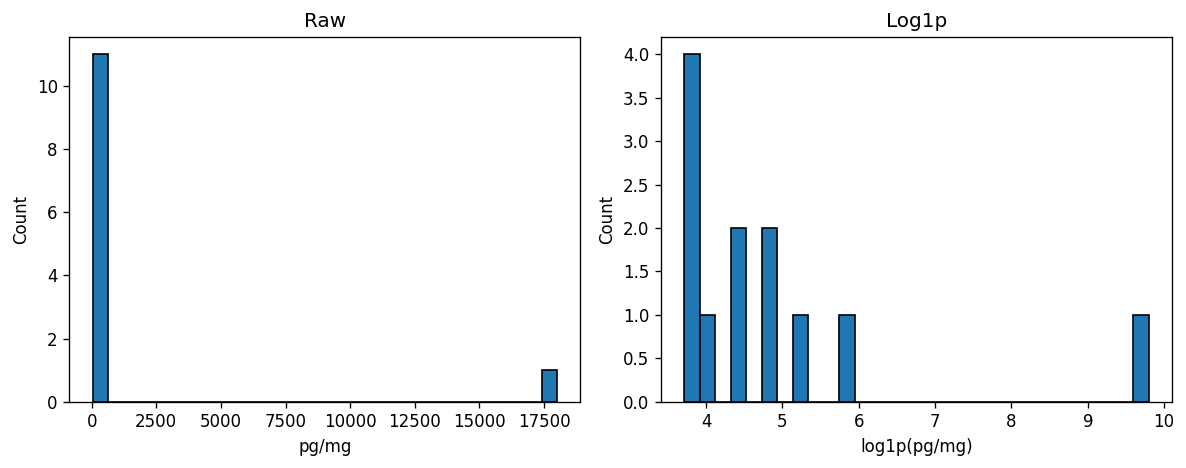

In [5]:
# 1.2A — STUDENT TODO: choose a variable to analyze
# Set to ONE of: HAIR_QNT_VARS
SELECT_QNT = 'su_y_hairtox__rslt__opi__cod_qnt'  # <-- CHANGE THIS if you want a different analyte

assert SELECT_QNT in HAIR_QNT_VARS, f"SELECT_QNT must be one of {HAIR_QNT_VARS}"
assert SELECT_QNT in df_out.columns, f"{SELECT_QNT} not found in df_out columns."

label = ANALYTE_LABEL.get(SELECT_QNT, SELECT_QNT)
s_raw = _num_clean(df_out[SELECT_QNT])

print(f"Analyte: {label} | Variable: {SELECT_QNT}")
display(s_raw.dropna().describe(percentiles=[.25,.5,.75]).to_frame().T)

# quick raw + log hist (no caps yet)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(s_raw.dropna(), bins=30, edgecolor="black")
ax[0].set_title("Raw"); ax[0].set_xlabel("pg/mg"); ax[0].set_ylabel("Count")
xlog = _log(s_raw, "log1p").dropna()
ax[1].hist(xlog, bins=30, edgecolor="black")
ax[1].set_title("Log1p"); ax[1].set_xlabel("log1p(pg/mg)"); ax[1].set_ylabel("Count")
plt.tight_layout(); plt.show()


## 1.3 — See your options (caps & counts)

We compute **all** candidate caps and show how many observations exceed each.  
This is where you **learn the options** before choosing one to apply.


In [6]:
# 1.3A — Compute candidate caps + over-counts

caps = compute_caps(s_raw, log_base="log1p")  # we teach on log1p by default
lit = LIT_UPPER.get(SELECT_QNT, np.inf)

over = {
    "log_iqr_upper": int(s_raw.gt(caps["log_iqr_upper"]).sum()),
    "log_p995":      int(s_raw.gt(caps["log_p995"]).sum()),
    "min_of_both":   int(s_raw.gt(caps["min_of_both"]).sum()),
    "literature":    int(s_raw.gt(lit).sum()) if np.isfinite(lit) else 0,
}

caps_tbl = pd.DataFrame({
    "cap_value": [caps["log_iqr_upper"], caps["log_p995"], caps["min_of_both"], lit],
    "n_above":   [over["log_iqr_upper"], over["log_p995"], over["min_of_both"], over["literature"]],
}, index=["log_iqr_upper","log_p995","min_of_both","literature_upper"]).round(2)

display(caps_tbl)

print("Interpretation guide:")
print("- log_iqr_upper: classic Tukey fence on log scale (robust).")
print("- log_p995: top 0.5% cutoff on log scale (robust, quantile-based).")
print("- min_of_both: conservative cap (choose the smaller cap).")
print("- literature_upper: audit only; use to flag plausibility, not as the applied cap.")


,cap_value,n_above
log_iqr_upper,791.83,1
log_p995,14483.44,1
min_of_both,791.83,1
literature_upper,20000.00,0


Interpretation guide:
- log_iqr_upper: classic Tukey fence on log scale (robust).
- log_p995: top 0.5% cutoff on log scale (robust, quantile-based).
- min_of_both: conservative cap (choose the smaller cap).
- literature_upper: audit only; use to flag plausibility, not as the applied cap.


## 1.4 — Choose ONE approach and apply it

We make **two separate decisions** here:  

- **APPROACH** = the rule for **defining the cap value** (Tier A). This is how you decide the threshold for “high” values.  
  Examples:  
  - `"log_iqr_upper"` → Tukey fence (Q3 + 1.5×IQR) on the log scale.  
  - `"log_p995"` → 99.5th percentile on the log scale.  
  - `"min_of_both"` → more conservative (smaller) of the two above.  
  - `"none"` → skip calculating/applying any robust cap.

- **ACTION** = what you actually **do** with that cap once chosen. In this lab, we will **always winsorize** values above the chosen cap in `df_out` (Tier A) while keeping the original values intact in `df_raw`.  
  Examples in other contexts might include `"transform_only"` (log scale, no capping) or `"none"` (no change).

We will also always add a **plausibility flag** for values above the **literature upper** (Tier B), even if no winsorizing is done. This ensures you can identify results that may be implausible given known toxicology ranges.


In [7]:
# 1.4A — STUDENT TODO: choose your approach and action
APPROACH = 'min_of_both'   # <-- CHANGE to "log_iqr_upper" | "log_p995" | "min_of_both" | "none"
ACTION   = 'winsorize'      # <-- "winsorize" | "transform_only" | "none"

assert APPROACH in {"log_iqr_upper","log_p995","min_of_both","none"}
assert ACTION in {"winsorize","transform_only","none"}

# pick cap
chosen_cap = np.inf if APPROACH=="none" else caps[APPROACH]

# materialize *_wz and *_log columns in df_out (do not overwrite original)
if ACTION == "winsorize" and np.isfinite(chosen_cap):
    s_wz = winsorize_upper(s_raw, chosen_cap)
else:
    s_wz = s_raw.copy()

s_log = _log(s_raw, "log1p")  # we report log1p summaries for skew

df_out[SELECT_QNT + "_wz"]  = s_wz
df_out[SELECT_QNT + "_log"] = s_log

# plausibility flag (always calculated if literature upper available)
if np.isfinite(lit):
    df_out[SELECT_QNT + "_plaus_flag"] = (s_raw > lit).astype("Int64")

print(f"Applied approach: {APPROACH} | ACTION: {ACTION}")
print(f"Chosen robust cap (pg/mg): {'∞' if not np.isfinite(chosen_cap) else round(chosen_cap,2)}")


Applied approach: min_of_both | ACTION: winsorize
Chosen robust cap (pg/mg): 791.83


## 1.5 — Before/After summaries (raw vs winsorized vs log)

Check how your choice impacts the distribution. We also report how many values exceed your **chosen cap** and the **literature upper**.


In [8]:
# 1.5A — Summary table + counts

summary_tbl = summarize_raw_wz_log(s_raw, df_out[SELECT_QNT + "_wz"], df_out[SELECT_QNT + "_log"])
display(summary_tbl)

n_over_cap = int(s_raw.gt(chosen_cap).sum()) if np.isfinite(chosen_cap) else 0
n_over_lit = int(s_raw.gt(lit).sum()) if np.isfinite(lit) else 0
print(f"Values > chosen robust cap: {n_over_cap}")
print(f"Values > literature upper (plausibility): {n_over_lit}")

# Save summary
out_csv = FIG_DIR / f"{SELECT_QNT}_outlier_summary_{APPROACH}.csv"
summary_tbl.to_csv(out_csv)
print(f"Saved: {out_csv}")


,raw,winsorized,log_scale
n,11680.000,11680.000,11680.000
n_missing,11668.000,11668.000,11668.000
pct_missing,99.897,99.897,99.897
mean,1595.766,161.585,4.855
median,83.440,83.440,4.435
sd,5167.353,216.617,1.694
p95,8290.266,545.688,7.624
p99,16059.653,742.598,9.363


Values > chosen robust cap: 1
Values > literature upper (plausibility): 0
Saved: figures/su_y_hairtox__rslt__opi__cod_qnt_outlier_summary_min_of_both.csv


## 1.6 — Visuals with markers

Two quick visuals:

1) **Raw scale** with vertical lines at **LOD=20**, **LOQ=40**, **literature upper**, and **chosen robust cap**.  
2) **Log scale** histograms **before vs after** winsorizing.

These make it obvious how your choice changes the tail.


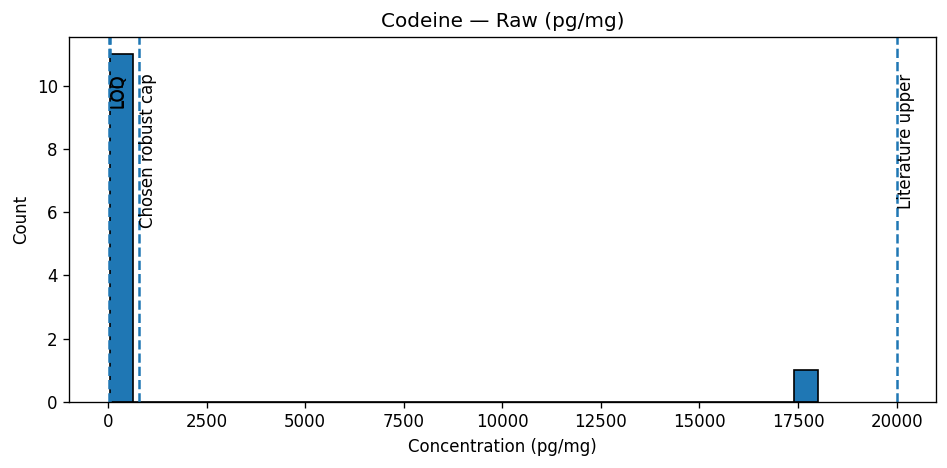

Saved: figures/su_y_hairtox__rslt__opi__cod_qnt_raw_hist_min_of_both.png


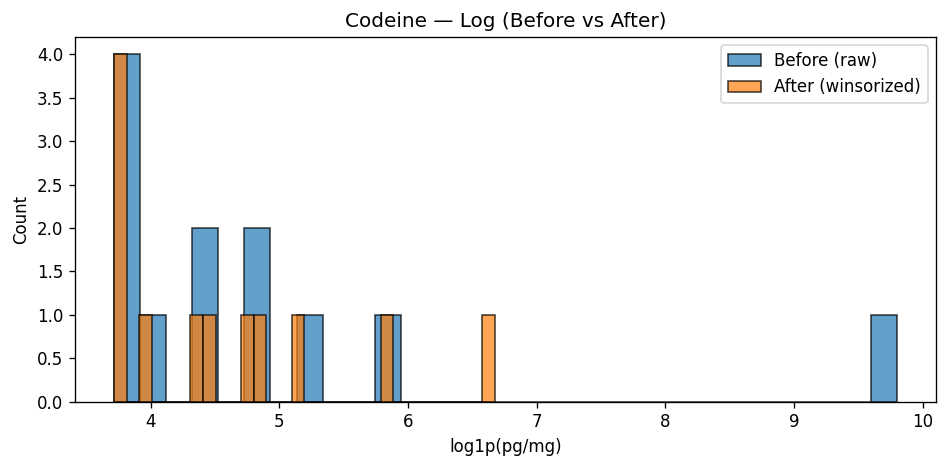

Saved: figures/su_y_hairtox__rslt__opi__cod_qnt_log_hist_before_after_min_of_both.png


In [9]:
# 1.6A — Plots

vals = s_raw.dropna()
if not vals.empty:
    # Raw scale
    plt.figure(figsize=(8,4))
    plt.hist(vals, bins=30, edgecolor="black")
    ymax = plt.ylim()[1]
    markers = [(LOD,"LOD"), (LOQ,"LOQ")]
    if np.isfinite(lit): markers.append((lit,"Literature upper"))
    if np.isfinite(chosen_cap): markers.append((chosen_cap,"Chosen robust cap"))
    for v, lbl in markers:
        plt.axvline(v, linestyle="--")
        plt.text(v, ymax*0.9, lbl, rotation=90, va="top")
    plt.title(f"{ANALYTE_LABEL.get(SELECT_QNT, SELECT_QNT)} — Raw (pg/mg)")
    plt.xlabel("Concentration (pg/mg)"); plt.ylabel("Count")
    plt.tight_layout()
    p1 = FIG_DIR / f"{SELECT_QNT}_raw_hist_{APPROACH}.png"
    plt.savefig(p1); plt.show(); print(f"Saved: {p1}")

    # Log scale before vs after
    raw_log = _log(s_raw, "log1p").dropna()
    wz_log  = _log(df_out[SELECT_QNT + "_wz"], "log1p").dropna()
    plt.figure(figsize=(8,4))
    plt.hist(raw_log, bins=30, alpha=0.7, label="Before (raw)", edgecolor="black")
    plt.hist(wz_log,  bins=30, alpha=0.7, label="After (winsorized)", edgecolor="black")
    plt.title(f"{ANALYTE_LABEL.get(SELECT_QNT, SELECT_QNT)} — Log (Before vs After)")
    plt.xlabel("log1p(pg/mg)"); plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    p2 = FIG_DIR / f"{SELECT_QNT}_log_hist_before_after_{APPROACH}.png"
    plt.savefig(p2); plt.show(); print(f"Saved: {p2}")
else:
    print("No non-missing values to plot.")


## 1.8 — Check your understanding - for your notes not for submission

- Name the **analyte** you worked on and the **approach you chose** (`log_iqr_upper`, `log_p995`, `min_of_both`, or `none`).  
- Report how many values exceeded your **chosen robust cap** and the **literature upper**.  
- Explain **why** your choice is appropriate for right-skewed hair data (why log? why this cap?).  
- Clarify that literature is a **plausibility flag**, not your operational cap.  


# 2.0 Inconsistencies: Discordance (Self-Report vs Hair Screen)

**Goal:** Build a simple **discordance flag** using only:
- **Past-year self-report** `su_y_sui__use__rxopi_001__l` (0 = denies use, 1 = yes)
- **Hair toxicology screen** `su_y_hairtox__rslt__opi_scrn` (0/1; **666 = QNS**)

**Definition (primary discordance):** `self-report == 0` **AND** `hair screen == 1` → flag = **1**  
This highlights cases where reported non-use conflicts with a positive screen.

**Data hygiene for this section**
- Convert ABCD special codes **777/888/999 → NaN** (not data).  
- Treat hair **666 (QNS) → NaN** (not evaluable; do not count as negative).

**What you’ll do in the TODO cell**
1. Fill in `SR_VAR` and `HAIR_VAR` with the exact column names above.  
2. Create `discordant_sr_no_hair_pos = 1` when **SR = 0** and **Hair = 1** (else 0/NA).  
3. Produce a **summary table** for SR, Hair, and the Discordant flag (n, missing %, n=1/n=0 of evaluable).  
4. Report **evaluable pairs (both present)** and **% discordant**.  
5. Draw a **plain-language bar chart** with three counts:  
   - “Discordant: Denied use + Hair positive”  
   - “Hair screen: Positive”  
   - “Self-report (past year): Yes”

**Why this matters (interpretation cues)**
- **Time window:** Hair ≈ past 1–3 months; SR is past year. SR-Yes + Hair-No can be a window mismatch.  
- **Screen vs confirm:** Screen positives may lack confirm/quant; QNS isn’t negative.  
- **Analysis choices:** You’ll later debate treating discordance as a covariate, using a conservative combine rule, or excluding discordant cases.

---

### 🤖 Copilot Prompts (use one at a time)

- *Explain in 3–4 sentences what “discordant (SR=0 & Hair=1)” means and why hair’s shorter detection window matters for interpretation.*  
- *Given the summary table (n, % missing, n₁/n₀) and the evaluable-pairs denominator, describe the discordance rate without quoting raw counts.*    
- *If the discordance rate were **~25%**, list two defensible handling strategies and one risk for each (bias vs. variance).*  
- *Draft a one-sentence caption that distinguishes “plausibility” (QNS/confirm issues) from “true disagreement” between measures.*


Summary table (saved to ./figures/discordance_summary_stats.csv):


,label,n,n_evaluable,n_missing,pct_missing,n_1,pct_1_of_evaluable,n_0,pct_0_of_evaluable
0,"Self-report (past year): Yes=1, No=0",11680,11615,65,0.556507,355,3.056393,11260,96.943607
1,"Hair screen: Positive=1, Negative=0",11680,2292,9388,80.376712,346,15.095986,1946,84.904014
2,Discordant: Denied use + Hair positive (flag=1),11680,11680,0,0.0,27,0.231164,11653,99.768836



Evaluable pairs (both present): 2285
Primary discordance (Denied use + Hair positive): 27 (1.18% of evaluable pairs)


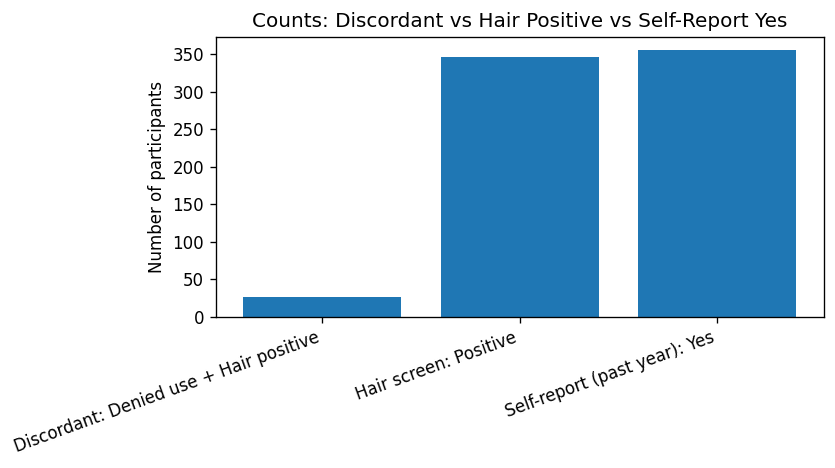

In [10]:
# 2. Build discordant flag, summarize, and plot (plain-language labels)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths & constants ---
FIG_DIR = Path("./figures")
FIG_DIR.mkdir(exist_ok=True)

# exact column names in df_raw
SR_VAR   = "su_y_sui__use__rxopi_001__l"   # self-report (past year): 0 = denies, 1 = yes
HAIR_VAR = "su_y_hairtox__rslt__opi_scrn" # hair screen: 0/1 (666=QNS)
SPECIAL_MISS = {777: np.nan, 888: np.nan, 999: np.nan}

# --- Guard for required columns ---
missing_cols = [c for c in [SR_VAR, HAIR_VAR] if c not in df_raw.columns]
if missing_cols:
    raise ValueError(f"Missing required column(s): {missing_cols}")

# --- Prepare data (standardize missing; hair QNS=666 -> NaN) ---
tmp = df_raw[[SR_VAR, HAIR_VAR]].copy().replace(SPECIAL_MISS)
tmp[SR_VAR]   = pd.to_numeric(tmp[SR_VAR], errors="coerce")          # 0/1/NaN
tmp[HAIR_VAR] = pd.to_numeric(tmp[HAIR_VAR], errors="coerce").replace({666: np.nan})  # 0/1/NaN

sr   = tmp[SR_VAR]
hair = tmp[HAIR_VAR]

# --- Discordant flag: Denied use (0) AND Hair positive (1) ---
discordant = ((sr == 0) & (hair == 1)).astype("Int64")   # TODO: Define values of sr and hair variables that define discordance
tmp["discordant_sr_no_hair_pos"] = discordant

# --- Summary stats helper (binary with NA) ---
def summarize_binary(s: pd.Series, label: str) -> pd.Series:
    n = len(s)
    n_missing = int(s.isna().sum())
    n_eval = n - n_missing
    n1 = int((s == 1).sum())
    n0 = int((s == 0).sum())
    return pd.Series({
        "label": label,
        "n": n,
        "n_evaluable": n_eval,
        "n_missing": n_missing,
        "pct_missing": (n_missing/n*100) if n else np.nan,
        "n_1": n1,
        "pct_1_of_evaluable": (n1/n_eval*100) if n_eval else np.nan,
        "n_0": n0,
        "pct_0_of_evaluable": (n0/n_eval*100) if n_eval else np.nan
    })

# --- Build summary table for SR, Hair, and the Discordant flag ---
summary = pd.concat([
    summarize_binary(sr,   "Self-report (past year): Yes=1, No=0"),
    summarize_binary(hair, "Hair screen: Positive=1, Negative=0"),
    summarize_binary(discordant, "Discordant: Denied use + Hair positive (flag=1)")
], axis=1).T

# Evaluable pair denominator and discordance %
evaluable_pairs = (~sr.isna()) & (~hair.isna())
n_pairs = int(evaluable_pairs.sum())
n_discordant = int(((sr == 0) & (hair == 1) & evaluable_pairs).sum())
pct_discordant_pairs = (n_discordant/n_pairs*100) if n_pairs else np.nan

print("Summary table (saved to ./figures/discordance_summary_stats.csv):")
display(summary.round(3))
print(f"\nEvaluable pairs (both present): {n_pairs}")
print(f"Primary discordance (Denied use + Hair positive): {n_discordant} "
      f"({pct_discordant_pairs:.2f}% of evaluable pairs)")

summary.to_csv(FIG_DIR / "discordance_summary_stats.csv", index=False)

# --- Plain-language bar chart: counts of Discordant vs Hair Positive vs SR Yes ---
labels = [
    "Discordant: Denied use + Hair positive",
    "Hair screen: Positive",
    "Self-report (past year): Yes"
]
counts = [
    n_discordant,
    int((hair == 1).sum()),
    int((sr == 1).sum())
]

plt.figure(figsize=(7, 4))
plt.bar(labels, counts)
plt.ylabel("Number of participants")
plt.title("Counts: Discordant vs Hair Positive vs Self-Report Yes")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "discordance_counts_plain_labels.png", dpi=200)
plt.show()


### 2. Your Turn

Insert the **discordance bar figure** into your reflection file and write **2–3 sentences**:
  - State the discordant count and % of evaluable cases.
  - Choose one handling rule—**keep a discordance covariate** (flag cases for adjustment in models), **conservative combine** (treat any “Yes” from self-report OR toxicology as use), or **exclude discordant cases** (remove from analysis entirely)—and explain why you would take this approach in the context of your research question. In your justification, address the trade-offs: how your choice affects sample size, bias, and interpretability; whether the decision leans toward minimizing false negatives, preserving validity of self-reported patterns, or avoiding measurement conflict altogether.
  - In real studies, discordance rates can be in the 15-20% range, imagine your data showed 25 percent discordance, would you take the same handling approach?
  - In both cases, discordance shows that self-report data always has some underreport error, how does this effect your analysis of substance use data?


## 3.0 — Orientation

**Part 3 — Missingness, Imputation, and Composite EDA**  
In this section, we will:  
1. Map missingness across the dataset.  
2. Audit three variable groups to understand *why* values are missing.  
3. Perform row-wise MCAR imputation for the peer items and then repeat the composite EDA from Lab 2.

**Groups we’ll examine:**
- **Hair toxicology** — patterns from collection procedures, `QNS=666`, and selective confirm/quant tests.  
- **SUI follow-ups** — asked only if prior “gate” variables are on (structured skips).  
- **Peer items** — `PBP 001–003`, `PGD 001–009`, plus `fc_y_pm_mean`; assume ≈5% MCAR.

**Deliverables from this section:**
- Missingness heatmap (`.png`)  
- Three summary tables (hair tox, SUI follow-ups, peer items)  
- “Before vs After” figures for PBP and PGD composites saved in `./figures/`


In [11]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)
SPECIAL_MISS = {777: np.nan, 888: np.nan, 999: np.nan}  # course standard

def existing(cols, df):
    return [c for c in cols if c in df.columns]

def missing_overview(df):
    rate = df.isna().mean().sort_values(ascending=False)
    return rate.to_frame("pct_missing").assign(pct_missing=lambda x: x["pct_missing"]*100)

def code_aware_missing_summary(raw_df, cols, extra_codes=(666,)):
    """Summarize NaN and special code counts for selected columns (use RAW df to count codes)."""
    cols = existing(cols, raw_df)
    rows, n = [], len(raw_df)
    for c in cols:
        s_raw = raw_df[c]
        row = {
            "variable": c,
            "n": n,
            "n_nan": int(pd.to_numeric(s_raw, errors="coerce").isna().sum()),
            "pct_nan": pd.to_numeric(s_raw, errors="coerce").isna().mean()*100,
        }
        for code in extra_codes:
            n_code = int((s_raw == code).sum())
            row[f"n_{code}"] = n_code
            row[f"pct_{code}"] = (n_code/n)*100
        rows.append(row)
    return pd.DataFrame(rows).sort_values("pct_nan", ascending=False).reset_index(drop=True)


## 3.2 — Heatmap of Missingness (Top 40 Columns)

We first standardize ABCD missing codes (`777`, `888`, `999` → `NaN`).  
For **hair toxicology** variables only, we also treat `666` (*Quantity Not Sufficient*, QNS) as missing for visualization purposes — but we will still report it as a special code in our summary table.

Then, we generate a heatmap of the **top 40 columns by % missing** and save it as a `.png` file.


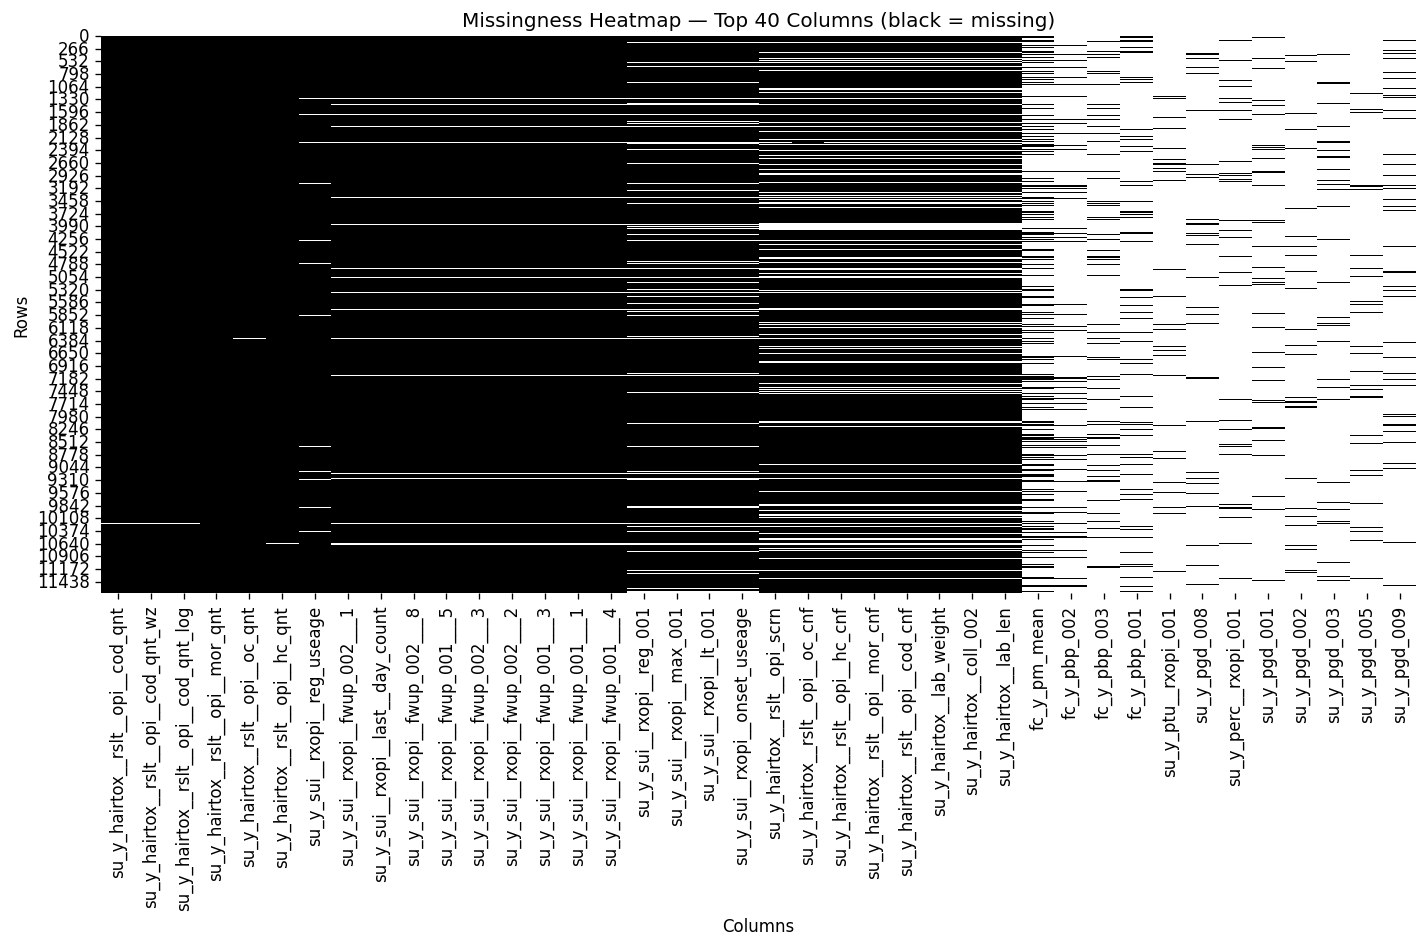

In [12]:
# Copy and standardize
df_heat = df_out.copy().replace(SPECIAL_MISS)

# Hair tox columns (declare once; used again below)
hair_cols = [
    "su_y_hairtox__coll_002",
    "su_y_hairtox__lab_len",
    "su_y_hairtox__lab_weight",
    "su_y_hairtox__rslt__opi_scrn",
    "su_y_hairtox__rslt__opi__hc_cnf",
    "su_y_hairtox__rslt__opi__hc_qnt",
    "su_y_hairtox__rslt__opi__oc_cnf",
    "su_y_hairtox__rslt__opi__oc_qnt",
    "su_y_hairtox__rslt__opi__cod_cnf",
    "su_y_hairtox__rslt__opi__cod_qnt",
    "su_y_hairtox__rslt__opi__mor_cnf",
    "su_y_hairtox__rslt__opi__mor_qnt",
]
hair_cols = existing(hair_cols, df_heat)

# Treat QNS=666 as NaN for hair tox visualization
for c in hair_cols:
    df_heat[c] = pd.to_numeric(df_heat[c], errors="coerce").replace({666: np.nan})

# Top 40 columns by missing rate
top_cols = missing_overview(df_heat).head(40).index


plt.figure(figsize=(12, 8))
sns.heatmap(df_heat[top_cols].isna(), cbar=False, cmap="binary")
plt.title("Missingness Heatmap — Top 40 Columns (black = missing)")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_heatmap_top40.png", dpi=200); plt.show()

# Save overall table for reference
missing_overview(df_heat).to_csv(FIG_DIR / "missing_rate_all_columns.csv")


## 3.3 — Interpreting the Heatmap: MCAR, MAR, MNAR

Use the heatmap to identify patterns of missingness:

- **MCAR** (*Missing Completely at Random*): Appears patternless; safe for simple methods such as row-wise mean/median imputation within a small, related block of variables.  
- **MAR** (*Missing At Random*): Missingness can be explained by other observed variables (e.g., hair not collected at remote visits; lab confirm tests only run on screens/priority panels).  
- **MNAR** (*Missing Not At Random*): Missingness depends on the unobserved value itself (e.g., youths less likely to disclose in follow-ups when use is heavier).

We'll now audit three variable groups for missingness patterns and potential mechanisms:  
1. **Hair toxicology**  
2. **SUI follow-ups**  
3. **Peer variables**

---

### Why Hair Toxicology Has High Missingness

Hair toxicology shows **systematic missingness** due to collection and testing protocols:

- **Remote visits:** Hair samples were not collected during remote assessments (affecting 2-year, 3-year, and early 4-year follow-ups).
- **Budget constraints:** Not all collected samples are tested. Initially, only ~5% of "high-risk" participants were analyzed annually; currently ~20% are tested, plus targeted 2% groups.
- **Quantity Not Sufficient (QNS, code 666):** Some samples lack the 100mg needed for a full panel; these are allocated by priority (cannabinoids first, then opioids, then prescribed drugs).
- **Screen-then-confirm workflow:** Confirmation and quantitation tests run **only if** immunoassay screens are positive (or for select analytes like THCCOOH/EtG). Negative screens yield no quant data.

**Classification:** This is **MAR** because missingness depends on **observed factors** (visit type, risk algorithm, screen results, sample weight)—not the unobserved concentration itself. 

**Implication:** Do **not** impute hair toxicology values naïvely. Treat QNS and untested samples as structurally missing; use them as covariates or exclude them based on your research question.

📖 *For full protocol details, see [ABCD Hair Toxicology Documentation](https://docs.abcdstudy.org/latest/documentation/non_imaging/su.html#su_y_hairtox).*

In [13]:
# --- Group definitions ---
# 1) Hair tox: use explicit list from above (already filtered)
hair_cols = existing(hair_cols, df_raw)

# 2) SUI follow-ups: discover by prefix (keeps this robust to column set)
sui_fw_cols = sorted([c for c in df_raw.columns if c.startswith("su_y_sui__rxopi__fwup_")])

# 3) Peer variables: pbp, pgd, and fc_y_pm_mean
pbp_items = existing(["fc_y_pbp_001","fc_y_pbp_002","fc_y_pbp_003"], df_raw)
pgd_items = existing([
    "su_y_pgd_001","su_y_pgd_002","su_y_pgd_003","su_y_pgd_004",
    "su_y_pgd_005","su_y_pgd_006","su_y_pgd_007","su_y_pgd_008","su_y_pgd_009"
], df_raw)
peer_extra = existing(["fc_y_pm_mean"], df_raw)
peer_cols = pbp_items + pgd_items + peer_extra

# Summaries (use RAW df to count special codes; treat 666 as special for hair tox)
hair_tbl = code_aware_missing_summary(df_raw, hair_cols, extra_codes=(666,777,888,999))
sui_tbl  = code_aware_missing_summary(df_raw, sui_fw_cols, extra_codes=(777,888,999))
peer_tbl = code_aware_missing_summary(df_raw, peer_cols, extra_codes=(777,888,999))

display(hair_tbl.head(12))
display(sui_tbl.head(12))
display(peer_tbl.head(12))

hair_tbl.to_csv(FIG_DIR / "missing_summary_hairtox.csv", index=False)
sui_tbl.to_csv(FIG_DIR / "missing_summary_sui_followups.csv", index=False)
peer_tbl.to_csv(FIG_DIR / "missing_summary_peer.csv", index=False)


,variable,n,n_nan,pct_nan,n_666,pct_666,n_777,pct_777,n_888,pct_888,n_999,pct_999
0,su_y_hairtox__rslt__opi__cod_qnt,11680,11668,99.897260,0,0.000000,0,0.0,0,0.0,0,0.0
1,su_y_hairtox__rslt__opi__mor_qnt,11680,11664,99.863014,0,0.000000,0,0.0,0,0.0,0,0.0
2,su_y_hairtox__rslt__opi__oc_qnt,11680,11663,99.854452,0,0.000000,0,0.0,0,0.0,0,0.0
3,su_y_hairtox__rslt__opi__hc_qnt,11680,11662,99.845890,0,0.000000,0,0.0,0,0.0,0,0.0
4,su_y_hairtox__rslt__opi_scrn,11680,9381,80.316781,7,0.059932,0,0.0,0,0.0,0,0.0
5,su_y_hairtox__lab_weight,11680,9381,80.316781,0,0.000000,0,0.0,0,0.0,0,0.0
6,su_y_hairtox__lab_len,11680,9381,80.316781,0,0.000000,0,0.0,0,0.0,0,0.0
7,su_y_hairtox__coll_002,11680,9381,80.316781,0,0.000000,0,0.0,0,0.0,0,0.0
8,su_y_hairtox__rslt__opi__oc_cnf,11680,9381,80.316781,4,0.034247,0,0.0,0,0.0,0,0.0
9,su_y_hairtox__rslt__opi__hc_cnf,11680,9381,80.316781,3,0.025685,0,0.0,0,0.0,0,0.0


,variable,n,n_nan,pct_nan,n_777,pct_777,n_888,pct_888,n_999,pct_999
0,su_y_sui__rxopi__fwup_001___1,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
1,su_y_sui__rxopi__fwup_001___3,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
2,su_y_sui__rxopi__fwup_001___4,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
3,su_y_sui__rxopi__fwup_001___5,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
4,su_y_sui__rxopi__fwup_002___1,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
5,su_y_sui__rxopi__fwup_002___2,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
6,su_y_sui__rxopi__fwup_002___3,11680,11325,96.960616,0,0.0,0,0.0,0,0.0
7,su_y_sui__rxopi__fwup_002___8,11680,11325,96.960616,0,0.0,0,0.0,0,0.0


,variable,n,n_nan,pct_nan,n_777,pct_777,n_888,pct_888,n_999,pct_999
0,fc_y_pm_mean,11680,3239,27.731164,0,0.0,0,0.0,0,0.000000
1,su_y_pgd_008,11680,607,5.196918,0,0.0,0,0.0,0,0.000000
2,su_y_pgd_001,11680,593,5.077055,0,0.0,0,0.0,0,0.000000
3,su_y_pgd_002,11680,579,4.957192,0,0.0,0,0.0,0,0.000000
4,su_y_pgd_003,11680,575,4.922945,0,0.0,0,0.0,0,0.000000
5,su_y_pgd_005,11680,574,4.914384,0,0.0,0,0.0,0,0.000000
6,su_y_pgd_009,11680,567,4.854452,0,0.0,0,0.0,0,0.000000
7,su_y_pgd_004,11680,563,4.820205,0,0.0,0,0.0,0,0.000000
8,su_y_pgd_006,11680,561,4.803082,0,0.0,0,0.0,0,0.000000
9,su_y_pgd_007,11680,539,4.614726,0,0.0,0,0.0,0,0.000000


## 3.5 — What to Write

**Short write-up (3–5 bullets):**
- Name **2–3 hair tox variables** with high % `NaN` and/or `666` (QNS); explain why this is expected based on collection patterns and selective confirm/quant testing.  
  *Reference:* [ABCD Hair Toxicology Documentation](https://docs.abcdstudy.org/latest/documentation/non_imaging/su.html#su_y_hairtox)  
- Name **2–3 SUI follow-up variables** with high missingness; explain that these are *structured skips* — asked only if a prior gate variable is “on.”  
- Name **2–3 peer variables** and explain why these appear closer to MCAR (small, random holes without clear dependency on other variables).  
- State which group(s) you would **never impute naïvely** (hair tox, SUI follow-ups) and which you **would** impute (peer). Include one sentence justification for each choice.


## 3.6 — MCAR Imputation (Row-wise Mean): Why, When, and How

In Part 3 we treat the **peer variables** as having ~5% **MCAR** (Missing Completely At Random): the chance a value is missing does **not** depend on the value itself or other measured fields in a systematic way. Under MCAR, simple, local fixes are acceptable because they don’t introduce directional bias.

**Row-wise mean imputation** fills a missing item for a participant using the **mean of the other items in the same row** (i.e., their own responses within a small, coherent block such as PBP/PGD). This keeps a person’s scale scores on their own response “profile,” instead of borrowing from group averages. It’s intentionally simple so you can see **before vs after** effects when you rebuild composites.

Guidelines:
- Use a **small, conceptually tight block** (here: PBP 001–003, PGD 001–009, plus `fc_y_pm_mean`).
- Convert ABCD special codes → `NaN` (we use `777/888/999 → NaN`).
- Create **new** columns with a `*_imp` suffix; never overwrite originals.
- Keep provenance: “before” = `df_out` (post-outliers), “after” = `df_imp` (imputed).


In [14]:
# 3.6 — Minimal core needed by 3.7/3.8 (MCAR row-wise mean + sum builders)

import numpy as np, pandas as pd

# Ensure SPECIAL_MISS is defined (already done earlier, but safe to redefine)
SPECIAL_MISS = {777: np.nan, 888: np.nan, 999: np.nan}

# Start from outlier-cleaned data (df_out) and replace special codes
df_imp = df_out.copy().replace(SPECIAL_MISS)

# Item blocks
pbp_items = [c for c in ["fc_y_pbp_001","fc_y_pbp_002","fc_y_pbp_003"] if c in df_imp.columns]
pgd_items = [c for c in [f"su_y_pgd_{i:03d}" for i in range(1,10)] if c in df_imp.columns]
peer_block = pbp_items + pgd_items + [c for c in ["fc_y_pm_mean"] if c in df_imp.columns]

# Row-wise MEAN imputation (MCAR)
block_num = df_imp[peer_block].apply(pd.to_numeric, errors="coerce")
row_mean = block_num.mean(axis=1, skipna=True)
for c in peer_block:
    df_imp[c + "_imp"] = pd.to_numeric(df_imp[c], errors="coerce").fillna(row_mean)

def build_sums_three_ways(df_before, df_after_imp, items, prefix):
    items = [c for c in items if c in df_before.columns]

    # BEFORE: replace special codes -> NaN, then compute strict & available
    before_block = df_before[items].replace(SPECIAL_MISS)
    before_num   = before_block.apply(pd.to_numeric, errors="coerce")
    n_items = len(items)
    strict = before_num.sum(axis=1, min_count=n_items)  # listwise
    avail  = before_num.sum(axis=1, min_count=1)        # available-case

    # AFTER: sum imputed items
    after_num = df_after_imp[[c + "_imp" for c in items]].apply(pd.to_numeric, errors="coerce")
    imp = after_num.sum(axis=1)

    # attach to df_after_imp so downstream code can find them
    df_after_imp[f"{prefix}_sum_strict"] = strict
    df_after_imp[f"{prefix}_sum_avail"]  = avail
    df_after_imp[f"{prefix}_sum_imp"]    = imp

## 3.7 — Demo: PBP Composite × DAPI (Before vs After Imputation)

We’ll rebuild the **PBP** composite two ways:
- **Before (strict/listwise)** from `df_out` → `pbp_sum_strict`
- **After (imputed)** from `df_imp` → `pbp_sum_imp`

Then we’ll compare each vs **DAPI** (`su_y_drgprob_prsum`) with:
- scatter plots,
- **Spearman’s rho**,
- a standard readout of **n, mean, sd** for the PBP axis (pairwise complete with DAPI).

Special codes `777/888/999 → NaN` are applied before any sums or correlations.


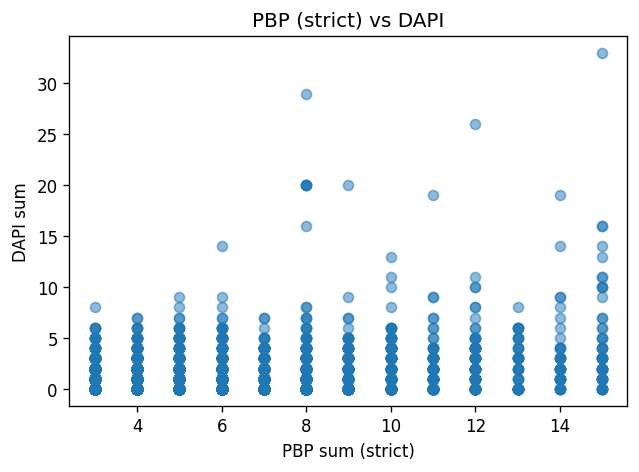

BEFORE — n=8550, mean=4.87, sd=2.48; Spearman rho=0.322, p=2.85e-205


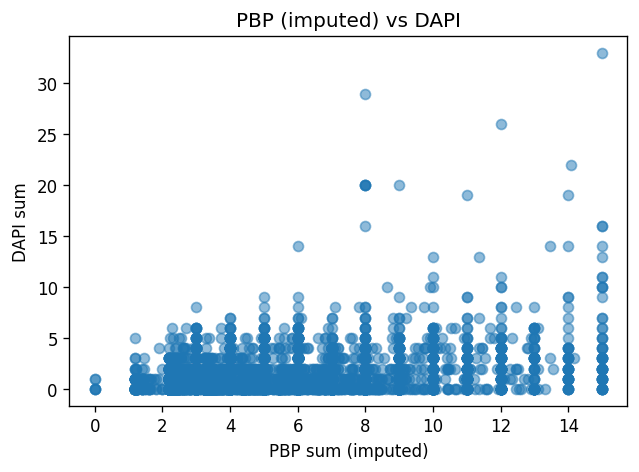

AFTER  — n=11625, mean=4.56, sd=2.50; Spearman rho=0.296, p=1.82e-233


In [15]:
# 3.7A — Demo code (ready to run)
from scipy.stats import spearmanr
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Ensure PBP sums exist (uses the 3.6 builder)
if "pbp_sum_strict" not in df_imp.columns or "pbp_sum_imp" not in df_imp.columns:
    build_sums_three_ways(df_out, df_imp, pbp_items, "pbp")

# PBP before/after
pbp_before = pd.to_numeric(df_imp["pbp_sum_strict"], errors="coerce")
pbp_after  = pd.to_numeric(df_imp["pbp_sum_imp"],    errors="coerce")

# DAPI (clean like Lab 2)
dapi = pd.to_numeric(df_raw["su_y_drgprob_prsum"], errors="coerce")
dapi = dapi.replace({777: np.nan, 888: np.nan, 999: np.nan})

def pair_stats(x, y):
    m = (~x.isna()) & (~y.isna())
    return int(m.sum()), x[m].mean(), x[m].std()

# BEFORE
mask_b = (~pbp_before.isna()) & (~dapi.isna())
plt.figure(figsize=(6,4))
plt.scatter(pbp_before[mask_b], dapi[mask_b], alpha=0.5)
plt.title("PBP (strict) vs DAPI"); plt.xlabel("PBP sum (strict)"); plt.ylabel("DAPI sum")
try: savefig("3_7_pbp_strict_vs_dapi"); 
except: pass
plt.show()

if mask_b.sum() > 1:
    rho_b, p_b = spearmanr(pbp_before[mask_b], dapi[mask_b])
    n_b, mu_b, sd_b = pair_stats(pbp_before, dapi)
    print(f"BEFORE — n={n_b}, mean={mu_b:.2f}, sd={sd_b:.2f}; Spearman rho={rho_b:.3f}, p={p_b:.3g}")
else:
    print("BEFORE — Not enough complete pairs.")

# AFTER
mask_a = (~pbp_after.isna()) & (~dapi.isna())
plt.figure(figsize=(6,4))
plt.scatter(pbp_after[mask_a], dapi[mask_a], alpha=0.5)
plt.title("PBP (imputed) vs DAPI"); plt.xlabel("PBP sum (imputed)"); plt.ylabel("DAPI sum")
try: savefig("3_7_pbp_imputed_vs_dapi"); 
except: pass
plt.show()

if mask_a.sum() > 1:
    rho_a, p_a = spearmanr(pbp_after[mask_a], dapi[mask_a])
    n_a, mu_a, sd_a = pair_stats(pbp_after, dapi)
    print(f"AFTER  — n={n_a}, mean={mu_a:.2f}, sd={sd_a:.2f}; Spearman rho={rho_a:.3f}, p={p_a:.3g}")
else:
    print("AFTER — Not enough complete pairs.")

# Sanity hint for students (PBP shouldn't be in the thousands)
if (pbp_before.max(skipna=True) or 0) > 200 or (pbp_after.max(skipna=True) or 0) > 200:
    print("Note: PBP looks unusually large. Ensure special codes were set to NaN before summing.")


### 🤖 Copilot prompts (3.7 Demo)
- “Summarize how **n, mean, sd, rho** changed from BEFORE to AFTER without quoting numbers; say whether each increased, decreased, or was stable.”
- “Give a one-sentence reason why Spearman is used for these composites instead of Pearson.”


## 3.8 — Your Turn: PGD Composite × (Pick a Numeric Variable)

**This task mirrors 3.7.** Use the 3.7 demo as your template: same workflow, same summary readout (**n, mean, sd, Spearman’s ρ**), just swapping in the **PGD composite** and a **numeric variable of your choice**.

**What to do**
1) Choose a numeric variable (e.g., `su_y_drgprob_prsum`, `fc_y_pm_mean`, `su_y_sui__rxopi__lt_001`, `su_y_sui__rxopi__onset_useage`).  
2) Make sure PGD sums exist (`pgd_sum_strict`, `pgd_sum_imp`) using the builder from 3.6.  
3) Plot **BEFORE (strict)** and **AFTER (imputed)** scatterplots with light transparency to reduce overplotting.  
4) Compute **Spearman’s ρ** for both, and print a standard readout: **n, mean, sd, rho, p**.  
5) Print a one‑liner: **Δn** and **Δρ** (imputed − strict).

> Hint: If you get weirdly large PGD values, you probably didn’t convert special codes (777/888/999) to `NaN` **before** summing. The 3.6 builder already handles this—reuse it as in 3.7.


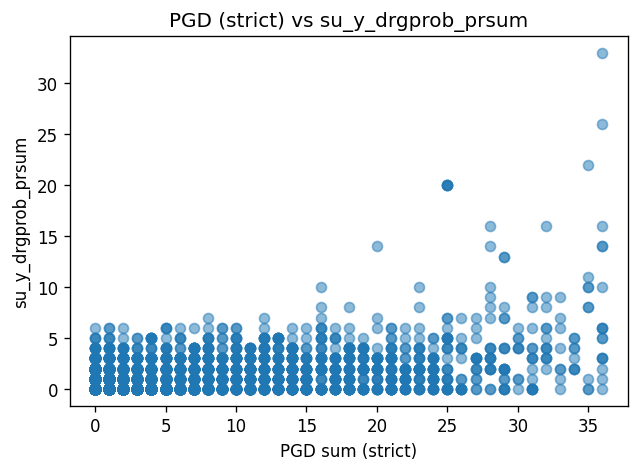

BEFORE — n=7412, mean=3.72, sd=6.49; Spearman rho=0.389, p=5.9e-266


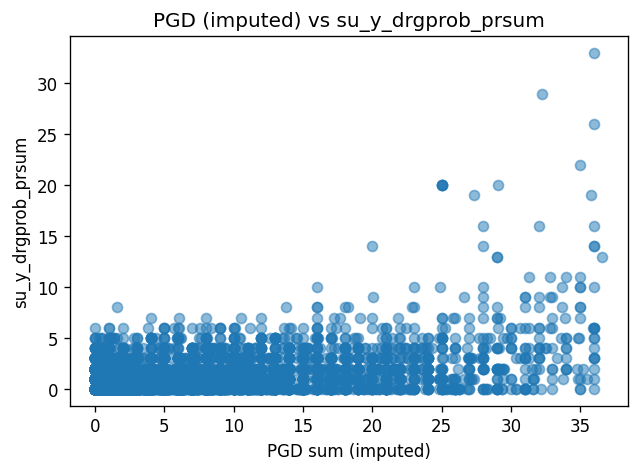

AFTER  — n=11625, mean=3.91, sd=6.46; Spearman rho=0.366, p=0
Δn = +4213; Δrho = -0.023 (imputed − strict)


In [16]:
# 3.8A — Your Turn (fill in the blanks; follow 3.7 as a guide)

from scipy.stats import spearmanr
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- 1) Choose the second numeric variable ---
num2_var = "su_y_drgprob_prsum"  # e.g., "su_y_drgprob_prsum" or "fc_y_pm_mean"

# Clean special codes like 3.7
num2 = pd.to_numeric(df_raw[num2_var], errors="coerce")
num2 = num2.replace({777: np.nan, 888: np.nan, 999: np.nan})

# --- 2) Ensure PGD sums exist (built in 3.6) ---
if "pgd_sum_strict" not in df_imp.columns or "pgd_sum_imp" not in df_imp.columns:
    build_sums_three_ways(df_out, df_imp, pgd_items, "pgd")

pgd_before = pd.to_numeric(df_imp["pgd_sum_strict"], errors="coerce")
pgd_after  = pd.to_numeric(df_imp["pgd_sum_imp"],    errors="coerce")

def pair_stats(x, y):
    m = (~x.isna()) & (~y.isna())
    return int(m.sum()), x[m].mean(), x[m].std(), m

# --- 3) BEFORE scatter + stats ---
n_b, mu_b, sd_b, mask_b = pair_stats(pgd_before, num2)
plt.figure(figsize=(6,4))
plt.scatter(pgd_before[mask_b], num2[mask_b], alpha=0.5)  # e.g., 0.5
plt.title(f"PGD (strict) vs {num2_var}")                         # fill with num2_var
plt.xlabel("PGD sum (strict)")                                         # e.g., "PGD sum (strict)"
plt.ylabel(f"{num2_var}")                                         # e.g., num2_var
try: savefig(f"3_8_pgd_strict_vs_{num2_var}")                     # fill with num2_var
except: pass
plt.show()

if n_b > 1:
    rho_b, p_b = spearmanr(pgd_before[mask_b], num2[mask_b])
    print(f"BEFORE — n={n_b}, mean={mu_b:.2f}, sd={sd_b:.2f}; Spearman rho={rho_b:.3f}, p={p_b:.3g}")
else:
    rho_b = np.nan
    print("BEFORE — Not enough complete pairs.")

# --- 4) AFTER scatter + stats ---
n_a, mu_a, sd_a, mask_a = pair_stats(pgd_after, num2)
plt.figure(figsize=(6,4))
plt.scatter(pgd_after[mask_a], num2[mask_a], alpha=0.5)   # e.g., 0.5
plt.title(f"PGD (imputed) vs {num2_var}")                        # fill with num2_var
plt.xlabel("PGD sum (imputed)")                                         # e.g., "PGD sum (imputed)"
plt.ylabel(f"{num2_var}")                                         # e.g., num2_var
try: savefig(f"3_8_pgd_imputed_vs_{num2_var}")                    # fill with num2_var
except: pass
plt.show()

if n_a > 1:
    rho_a, p_a = spearmanr(pgd_after[mask_a], num2[mask_a])
    print(f"AFTER  — n={n_a}, mean={mu_a:.2f}, sd={sd_a:.2f}; Spearman rho={rho_a:.3f}, p={p_a:.3g}")
else:
    rho_a = np.nan
    print("AFTER — Not enough complete pairs.")

# --- 5) One-liner deltas (imputed − strict) ---
delta_n = (n_a - n_b)
delta_rho = (rho_a - rho_b) if np.isfinite(rho_a) and np.isfinite(rho_b) else np.nan
print(f"Δn = {delta_n:+d}; Δrho = {delta_rho:+.3f} (imputed − strict)")


### 🤖 Copilot prompts (use one at a time)

- “Using the BEFORE and AFTER summary readouts (n, mean, sd, rho, p), describe whether each measure **increased, decreased, or stayed similar** after imputation—avoid quoting the actual numbers.”
- “Explain in 2–3 sentences why **Spearman’s ρ** is appropriate for PGD composites and many ABCD variables (discrete, skewed, with ties).”
- “Write one sentence on how **row‑wise mean imputation** can change **n** and potentially **ρ**, even under MCAR.”
- “Suggest a **figure caption** for the two scatter plots that helps a non‑technical reader understand what changed from BEFORE to AFTER.”


# Lab 3 — Autograder Checklist & Grade Rubric *(Dataset-Free)* (**50 pts**)

This autograder **does not execute your notebook or require any dataset**.  
It parses `Lab3.ipynb` and checks for **variable names, assignments, and code patterns**.  
Keep the **exact names** and show the required **expressions** in code cells.

---

## ✅ What you must include (names & patterns must match)

**You may choose any valid columns**, but your code must define the items below exactly as named.

### 1) Notebook Load & Setup
- `df` must be assigned by reading the CSV with `pd.read_csv(...)` into **exactly** `df`.
- No unfinished placeholders: all `___` in the provided starter cells must be replaced.

### 2) Outlier Handling — Hair Toxicology
- A variable (e.g., `cap_choice`) must be set to **one** of the approved strings:  
  `"log_iqr_upper"`, `"log_p995"`, `"min_of_both"`, `"none"`.
- Code must apply the selected approach to the variable chosen for outlier analysis.
- A plausibility flag must be created for values above the **literature upper**.

### 3) Inconsistencies — Discordant Flag
- Uses `SR_VAR` and `HAIR_VAR` from the approved list for past-year self-report and hair screen.
- Special codes replaced exactly as shown: `{777: np.nan, 888: np.nan, 999: np.nan}`, plus hair `666 → NaN`.
- Discordant flag defined as: `(sr == 0) & (hair == 1)` (with correct `.astype("Int64")`).
- Summary table built with the helper function from starter code and includes the discordant flag.

### 4) Bivariate — 3.8 “Your Turn” (Mirrors 3.7)
- Creates a sum variable from the `pgd_items` list (exact 8 items) with special code replacement `{777: np.nan, 999: np.nan}`.
- Selects `num2_var` from the approved numeric list.
- Scatter plot created with correct `plt.scatter(...)` call and `savefig` filename:  
  `q8_scatter_pgd_vs_{num2_var}`.
- Spearman correlation computed with `spearmanr(...)` using a `mask` to drop missing pairs.

---

## 🧪 Grade Rubric (how points are earned)

### 1) Smoke & Structure (**10 pts**)
- **5 pts** — All placeholders `___` are replaced; no `TODO` or unfinished code remains.
- **5 pts** — `df` is assigned from `pd.read_csv(...)` exactly.

### 2) Outlier Handling (**10 pts**)
- **4 pts** — `cap_choice` set to one of the four approved strings.
- **6 pts** — Code applies the chosen method and defines a plausibility flag above literature upper.

### 3) Inconsistencies — Discordant Flag (**10 pts**)
- **4 pts** — Correct `SR_VAR`/`HAIR_VAR` used, special code replacement exact.
- **6 pts** — Discordant flag formula correct and summary table includes it.

### 4) Bivariate — 3.8 Sum Creation (**10 pts**)
- **5 pts** — Correct PGD sum from 8 items with special code replacement.
- **5 pts** — `num2_var` set from approved list.

### 5) Bivariate — 3.8 Plot & Correlation (**10 pts**)
- **4 pts** — Scatter plot with correct labels, alpha, and save filename.
- **6 pts** — Spearman correlation computed correctly with a missing-data mask.

**Total = 50 pts**

---

## ☑️ Quick Pre-Submission Checklist

- [ ] All `___` replaced; no `TODO` markers remain.
- [ ] I loaded the dataset with `df = pd.read_csv(...)`.
- [ ] I set `cap_choice` to one of: `"log_iqr_upper"`, `"log_p995"`, `"min_of_both"`, `"none"`.
- [ ] I created a plausibility flag for values above literature upper.
- [ ] I used correct variable names for past-year self-report and hair screen, replaced special codes, and built the discordant flag.
- [ ] My summary table includes the discordant flag row.
- [ ] I built the PGD sum from exactly 8 items with `{777: np.nan, 999: np.nan}` replacement.
- [ ] I set `num2_var` from the approved list.
- [ ] My scatter plot and save filename match the required format.
- [ ] I computed Spearman correlation using a `mask` to drop missing pairs.

---

## 🔎 Common Pitfalls

- Leaving `___` in place.
- Using unapproved column names.
- Misspelling `cap_choice` or using the wrong string.
- Forgetting `.astype("Int64")` for the discordant flag.
- Changing the save filename format.
- Missing `{777: np.nan, 999: np.nan}` replacement.

---

## 📤 Submission

Upload **only** `Lab3.ipynb` to Gradescope. The autograder reads your notebook and checks for the required names and code patterns — **no dataset needed**.


# Citations

### Benchmarking Hair Toxicology Outliers (with citations)

Use these published anchors (pg/mg) plus ABCD vendor thresholds (**LOQ = 40**, **LOD = 20**) when deciding whether to **keep**, **cap**, or **transform** a flagged value. For this lab, treat the listed “upper benchmark” as a practical ceiling unless you can justify a unit correction (e.g., ÷1000 for ng→pg).

- **Hydrocodone**  
  - **Upper benchmark for this lab:** **15,000 pg/mg**  
  - Notes: Positive hair concentrations are typically in the low 10²–10³ pg/mg range; higher values occur in heavy/chronic use but are uncommon in community samples.  
  - **Citation:** Christine Moore, Michael Feldman, Edward Harrison, Sumandeep Rana, Cynthia Coulter, David Kuntz, Alpana Agrawal, Michael Vincent, James Soares. *Disposition of Hydrocodone in Hair.* **Journal of Analytical Toxicology** 30(6):353–359, 2006.

- **Codeine**  
  - **Upper benchmark for this lab:** **20,000 pg/mg**  
  - Notes: Confirmed positives often fall below a few thousand pg/mg; higher values occur in some users but remain rare.  
  - **Citation:** Christine Moore, Michael Feldman, Edward Harrison, Sumandeep Rana, Cynthia Coulter, David Kuntz, Alpana Agrawal, Michael Vincent, James Soares. *Disposition of Hydrocodone in Hair.* **Journal of Analytical Toxicology** 30(6):353–359, 2006. (Includes codeine data in the study.)

- **Oxycodone**  
  - **Upper benchmark for this lab:** **26,000 pg/mg**  
  - Notes: Large series report typical oxycodone positives in the 10³ pg/mg range, with upper observations reaching the mid-10⁴ pg/mg.  
  - **Citation:** Reisfield GM, Jones JT. *The Disposition of Oxycodone and Metabolite in Human Hair.* **Journal of Analytical Toxicology** 39(9):746–750, 2015. doi:10.1093/jat/bkv076.

- **Morphine**  
  - **Upper benchmark for this lab:** **13,000 pg/mg**  
  - Notes: Segmental testing in chronic users shows high values up to ~1.3×10⁴ pg/mg; single-use cases are typically much lower.  
  - **Citation:** Madry MM, Poetzsch SN, Steuer AE, Kraemer T, Baumgartner MR. *Significance of Metabolite Ratios in the Interpretation of Segmental Hair Testing Results—Differentiation of Single from Chronic Morphine Use in a Case Series.* **Metabolites** 11(8):557, 2021. PMCID: PMC8400298.

